In [39]:
import pandas as pd
import re, ast
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

In [3]:
DATASET_FILE_PATH = "australian_user_reviews.json"

## Data Loading

In [4]:
def parse_steam_date(date_str):
    date_str = date_str.replace("Posted ", "").replace(".", "")
    
    if re.search(r'\d{4}$', date_str):
        fmt = "%B %d, %Y"
    else:
        date_str += ", 2016" 
        fmt = "%B %d, %Y"
        
    try:
        return datetime.strptime(date_str, fmt)
    except ValueError:
        return None 

In [5]:
def parse_helpful(helpful_str):
    if "No ratings yet" in helpful_str:
        return 0.0
    
    match = re.search(r'(\d+) of (\d+)', helpful_str)
    if match:
        numerator = int(match.group(1))
        denominator = int(match.group(2))
        if denominator == 0: return 0.0
        return numerator / denominator
    return 0.0

In [6]:
with open(DATASET_FILE_PATH, 'r', encoding='utf-8') as f:
    data = [ast.literal_eval(line) for line in f]

## Data processing
Removing all the entries without a properly formed date to avoid issues with not properly forming validation and test sets later on. 

In [7]:
rows = []
for user in data:
    user_id = user['user_id']
    for review in user['reviews']:
        rows.append({
            'user_id': user_id,
            'item_id': review['item_id'],
            'recommend': 1 if review['recommend'] else 0,
            'date': parse_steam_date(review['posted']),
            'helpful_score': parse_helpful(review['helpful']),
            'review_text': review['review'] 
        })

In [38]:
df = pd.DataFrame(rows)
df = df.dropna(subset=['date'])
df = df.sort_values(by='date')

print(f"Total interactions: {len(df)}")
df.head()

Total interactions: 59305


,user_id,item_id,recommend,date,helpful_score,review_text
20764,TheWhipster,39690,1,2010-10-16,0.400000,You'll Be Emo'd by the end of it!
29168,eddy96,40700,1,2010-10-25,0.000000,A very addictive puzzle game with incredible a...
29807,farsel,24010,1,2010-11-19,0.416667,this is the most epic of epics and these train...
29804,farsel,25700,1,2010-11-20,0.714286,"im mad about balls, and this game"
29801,farsel,15320,1,2010-11-20,0.888889,brill plane simulator where you can do some si...


## Data analysis

In [9]:
n_users = df['user_id'].nunique()
n_items = df['item_id'].nunique()
n_interactions = len(df)

matrix_size = n_users * n_items
sparsity = (1 - (n_interactions / matrix_size)) * 100

print(f"--- DATASET STATISTICS ---")
print(f"Number of Users: {n_users}")
print(f"Number of Items (Games): {n_items}")
print(f"Total Interactions (Reviews): {n_interactions}")
print(f"Sparsity: {sparsity:.4f}%")
print(f"Date Range: {df['date'].min().date()} to {df['date'].max().date()}")

--- DATASET STATISTICS ---
Number of Users: 25458
Number of Items (Games): 3682
Total Interactions (Reviews): 59305
Sparsity: 99.9367%
Date Range: 2010-10-16 to 2016-09-18


The matrix is extremely sparse. This means standard correlation methods might not work very well. We might need dimensionality reduction techniques like Matrix Factorization.

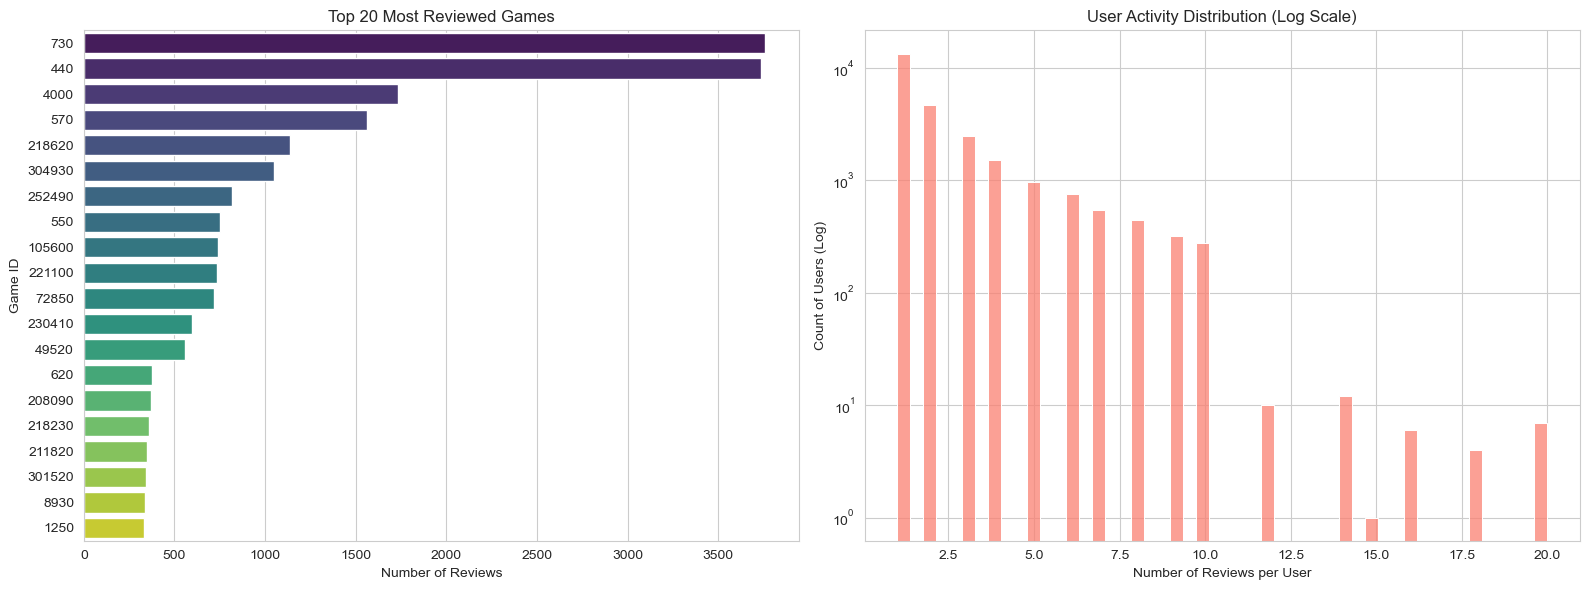

In [10]:
sns.set_style("whitegrid")

# How many reviews the user made
user_activity = df.groupby('user_id').size()

# How many users that review the item
item_popularity = df.groupby('item_id').size()

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Get the top 20 most popular games that were review
top_items = item_popularity.sort_values(ascending=False).head(20)
sns.barplot(x=top_items.values, y=top_items.index.astype(str), ax=ax[0], palette="viridis", hue=top_items.index.astype(str), legend=False)
ax[0].set_title("Top 20 Most Reviewed Games")
ax[0].set_xlabel("Number of Reviews")
ax[0].set_ylabel("Game ID")

# Get the distribution of the number fo reviews per user
# So we that users made less reviews than other reviews
sns.histplot(user_activity, bins=50, ax=ax[1], kde=False, color="salmon")
ax[1].set_yscale('log') # Log scale is here because of the huge variance
ax[1].set_title("User Activity Distribution (Log Scale)")
ax[1].set_xlabel("Number of Reviews per User")
ax[1].set_ylabel("Count of Users (Log)")

plt.tight_layout()
plt.show()

The data is highly skewed. A simple 'Most Popular' baseline will likely be very hard to beat because most users just play the popular games.

In [11]:
cold_start_users = (user_activity < 5).sum()
print(f"\n--- COLD START CHECK ---")
print(f"Users with < 5 reviews: {cold_start_users} ({cold_start_users/n_users:.1%} of total)")


--- COLD START CHECK ---
Users with < 5 reviews: 22124 (86.9% of total)


## Utility functions

In [12]:
def split_train_test(group):
    # If user has only 1 review, putting it in Test means we have 0 training data for them.
    # So we put it in Train to help learn global popularity.
    if len(group) < 2:
        return pd.DataFrame({
            'user_id': group['user_id'],
            'item_id': group['item_id'],
            'recommend': group['recommend'],
            'set': 'train' 
        })
    
    # If user has > 1 reviews, the LAST one is Test, the rest are Train
    else:
        group = group.copy()
        group['set'] = 'train'
        # Mark the very last interaction as 'test'
        group.iloc[-1, group.columns.get_loc('set')] = 'test'
        return group

In [13]:
df = df.sort_values(by=['user_id', 'date'])
df_split = df.groupby('user_id', group_keys=False).apply(split_train_test)

train_df = df_split[df_split['set'] == 'train'].drop(columns=['set'])
test_df = df_split[df_split['set'] == 'test'].drop(columns=['set'])

print(f"Training Set Size: {len(train_df)} interactions")
print(f"Test Set Size:     {len(test_df)} interactions")
print(f"Users in Test Set: {test_df['user_id'].nunique()}")
print(f"Total Users:       {df['user_id'].nunique()}")

Training Set Size: 47242 interactions
Test Set Size:     12063 interactions
Users in Test Set: 12063
Total Users:       25458


/var/folders/v0/bskv74p54wg2s9fyrxpt1sc00000gn/T/ipykernel_5831/2723179381.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_split = df.groupby('user_id', group_keys=False).apply(split_train_test)


## Baseline model

Calculate the top $K$ most recommended games. For each user, if the game they interacted with is in the top $K$ recommended games, predict recommend. 

In [81]:
y_test = test_df['recommend'].values
positive_interactions = train_df[train_df['recommend'] == 1]
game_popularity = positive_interactions['item_id'].value_counts()

def popularity_baseline_predict(item_ids, top_k_set):
    return [1 if item in top_k_set else 0 for item in item_ids]

num_unique_train_games = train_df['item_id'].nunique()
print(f"Number of unique games in training set: {num_unique_train_games}")

Number of unique games in training set: 2899


In [74]:
K = 10
top_k_recommended_games = set(game_popularity.head(K).index)
y_pred_pop = popularity_baseline_predict(test_df['item_id'], top_k_recommended_games)

print("--- POPULARITY THRESHOLD BASELINE ---")
print(f"--- TOP {K} MOST RECOMMENDED GAMES ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_pop):.4f}")
print(classification_report(y_test, y_pred_pop))

--- POPULARITY THRESHOLD BASELINE ---
--- TOP 10 MOST RECOMMENDED GAMES ---
Accuracy: 0.3013
              precision    recall  f1-score   support

           0       0.16      0.85      0.27      1844
           1       0.88      0.20      0.33     10211

    accuracy                           0.30     12055
   macro avg       0.52      0.53      0.30     12055
weighted avg       0.77      0.30      0.32     12055



Explore how the accuracy changes as $K$ changes. 

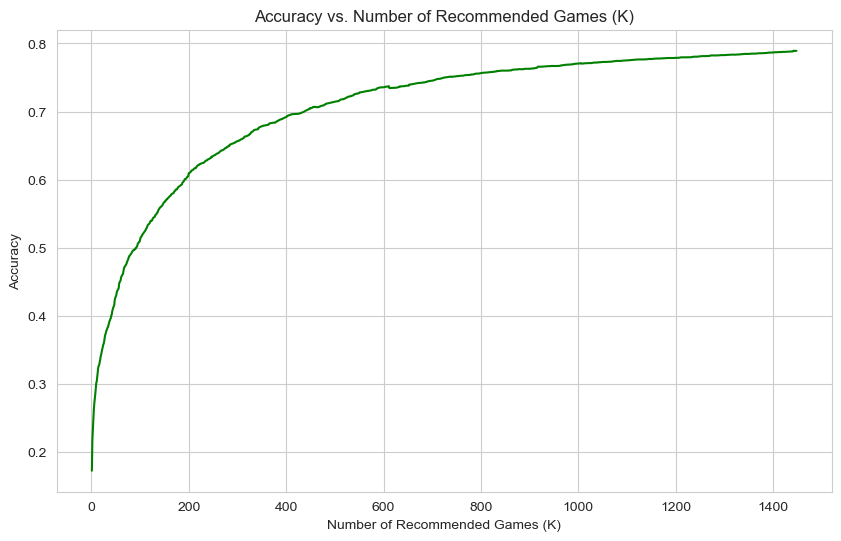

Peak accuracy: 78.94%


In [78]:
accuracies = []
for k in range(1, num_unique_train_games // 2): 
    top_k_recommended_games = set(game_popularity.head(k).index)
    y_pred_pop = popularity_baseline_predict(test_df['item_id'], top_k_recommended_games)
    accuracies.append(accuracy_score(y_test, y_pred_pop))
    
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracies) + 1), accuracies, color='green')
plt.title("Accuracy vs. Number of Recommended Games (K)")
plt.xlabel("Number of Recommended Games (K)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

print(f"Peak accuracy: {max(accuracies) * 100:.2f}%")

As we start expanding our set of top $K$ recommended games to include half of the most recommended games in the training set, the accuracy approaches around 80%. This is what we need to beat. 

## Amith's model


As it stands, we're currently trying to predict whether a user would like a game given the most k popular games. As it stands, only leads to a 20% accuracy. What we would by trying is taking a look at the reviews of the game and see if the user like the game or not. 


In [22]:
# Solution 2
# We'll define a representation for the document and use that representation to determine whether or the user recommends a game
# or not
# Let's start by using a word2vec model
from gensim.models import Word2Vec
import nltk
nltk.download('corpus')
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from nltk.stem import PorterStemmer
from sklearn import linear_model


[nltk_data] Error loading corpus: Package 'corpus' not found in index
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jishnuraychaudhuri/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [23]:
# Firstly, we create our sentences from the training data
def preprocess_text(df):
    # Create list of sentences, which is a list of words for each text in the training data
    setences = []
    outcomes = []

    # Set up to filter out the punctuation and stopwords from the text
    # Including a stemming algorithm as well
    punctuation = set(string.punctuation)
    filter = set(stopwords.words('english'))
    porter = PorterStemmer()

    for index, row in df.iterrows():
        # If the text is NaN 
        text = row["review_text"]

        # Firstly cover the text to capital 
        r = ''.join([c for c in text.lower() if c not in punctuation])

        # Next split the words
        words = r.split()

        # Filter out the words for stop words
        #words = [word for word in words if not word in filter]

        # Stem the words out
        words = [porter.stem(word) for word in words]

        if len(words) == 0:
            words = ["<unk>"]

        # Add words to setneces
        setences.append(words)
        outcomes.append(row["recommend"])
    
    return setences, outcomes



In [28]:
# Filter out the rows in the dataframe that doesn't have text
df_split = df.groupby('user_id', group_keys=False).apply(split_train_test)

train_df = df_split[df_split['set'] == 'train'].drop(columns=['set']).dropna(subset=['review_text'])
train_df = train_df[train_df['review_text'].apply(lambda x: not x.isspace())]
test_df = df_split[df_split['set'] == 'test'].drop(columns=['set']).dropna(subset=['review_text'])
test_df = test_df[test_df['review_text'].apply(lambda x: not x.isspace())]

print(f"Training Set Size: {len(train_df)} interactions")
print(f"Test Set Size:     {len(test_df)} interactions")
print(f"Users in Test Set: {test_df['user_id'].nunique()}")
print(f"Total Users:       {df['user_id'].nunique()}")

Training Set Size: 33842 interactions
Test Set Size:     12062 interactions
Users in Test Set: 12062
Total Users:       25458


/var/folders/v0/bskv74p54wg2s9fyrxpt1sc00000gn/T/ipykernel_5831/3739515139.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_split = df.groupby('user_id', group_keys=False).apply(split_train_test)


In [29]:
sentences = preprocess_text(train_df)


In [30]:
# Next create word2vec model
def train_word2vec(sentences, min_count=1, vector_size=10, window=3, sg=0):
    model = Word2Vec(sentences, vector_size=vector_size, min_count=min_count, window=window, sg=sg)
    return model

In [31]:
# We want to create a text representation of the words, so we have to combine the word embeddigns from word2vec
def create_sentence_embedding(sentence, model):
    # Go through each word in the sentence
    sentence_embed = []

    for word in sentence:
        if word in model.wv.key_to_index:
            sentence_embed.append(np.array(model.wv[word]))
        else:
            sentence_embed.append(np.array(model.wv['<unk>']))
    sentence_embed = np.array(sentence_embed).mean(axis=0)
    return sentence_embed

In [32]:
# Next, create a neural network that will take a sentence embedding and predict whether the user will recommend the game 
# Or not
# We could simply using a logistic regression algorithm with the word embeddings
df_split = df.groupby('user_id', group_keys=False).apply(split_train_test)

train_df = df_split[df_split['set'] == 'train'].drop(columns=['set']).dropna(subset=['review_text'])
train_df = train_df[train_df['review_text'] != ""]
test_df = df_split[df_split['set'] == 'test'].drop(columns=['set']).dropna(subset=['review_text'])
test_df = test_df[test_df['review_text'] != ""]

train_sentences, train_outcomes = preprocess_text(train_df)
test_sentences, test_outcomes  = preprocess_text(test_df)

print(f"Training Set Size: {len(train_df)} interactions")
print(f"Test Set Size:     {len(test_df)} interactions")
print(f"Users in Test Set: {test_df['user_id'].nunique()}")
print(f"Total Users:       {df['user_id'].nunique()}")

word_model = train_word2vec(train_sentences,sg=0)
train_sentences = np.array([create_sentence_embedding(sentence, word_model) for sentence in train_sentences])
test_sentences = np.array([create_sentence_embedding(sentence, word_model) for sentence in test_sentences])

log_model = linear_model.LogisticRegression(penalty='l2', class_weight='balanced', C=1, max_iter=500)
log_model.fit(train_sentences, train_outcomes)


test_predictions = log_model.predict(test_sentences)
train_predcitions = log_model.predict(train_sentences)
train_correct = train_predcitions == train_outcomes
test_correct = test_predictions == test_outcomes

train_correct = sum(train_correct) / len(train_correct)
test_correct = sum(test_correct) / len(test_correct)

print(f"Training Accuracy: {train_correct * 100}%")
print(f"Test Accuracy: {test_correct * 100}%")



/var/folders/v0/bskv74p54wg2s9fyrxpt1sc00000gn/T/ipykernel_5831/2458097527.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_split = df.groupby('user_id', group_keys=False).apply(split_train_test)


Training Set Size: 33834 interactions
Test Set Size:     12055 interactions
Users in Test Set: 12055
Total Users:       25458


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Training Accuracy: 61.31701838387421%
Test Accuracy: 55.99336374948154%
